In [1]:
import jax
import jax.numpy as jnp
from jax import Array
from ml_collections import config_flags
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from ddprism.corrupted_mnist import datasets
from ddprism.metrics import metrics, image_metrics
from ddprism.corrupted_mnist import config_base_grass
from ddprism.corrupted_mnist import config_base_mnist

import clvm

import math
from typing import Any, Callable, Mapping, Sequence, Tuple, Optional
from einops import rearrange

from tqdm import tqdm
import optax
from flax import linen as nn
from flax.training import train_state, orbax_utils

2025-07-24 11:32:38.979322: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753371158.994373  672058 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753371158.999007  672058 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1753371159.011155  672058 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1753371159.011170  672058 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1753371159.011171  672058 computation_placer.cc:177] computation placer alr

In [2]:
imagenet_path = '/mnt/home/aakhmetzhanova/ceph/galaxy-diffusion/corrupted-mnist/dataset/grass_jpeg/' 

## 1. Load grass and MNIST + grass datasets

### 1.1 Training set

In [3]:
# Generate train dataset with corrupted mnist digits.
config_mnist = config_base_mnist.get_config()
rng = jax.random.key(config_mnist.rng_key)
rng_dataset, rng_comp, rng = jax.random.split(rng, 3)

f_train = datasets.get_corrupted_mnist(
    rng_dataset, grass_amp=1., mnist_amp=config_mnist.mnist_amp,
    imagenet_path=imagenet_path,
    dataset_size=config_mnist.dataset_size,
    zeros_and_ones=True
)

# Generate train dataset with uncorrupted mnist digits for computing metrics later on.
f_train_uncorrupted = datasets.get_corrupted_mnist(
    rng_dataset, grass_amp=0., mnist_amp=1.,
    imagenet_path=imagenet_path,
    dataset_size=config_mnist.dataset_size,
    zeros_and_ones=True
)

In [4]:
# Generate train dataset with grass
config = config_base_grass.get_config()
rng = jax.random.key(config.rng_key)
rng_dataset, rng_comp, rng = jax.random.split(rng, 3)
b_train = datasets.get_corrupted_mnist(
    rng_dataset, grass_amp=1., mnist_amp=0.,
    imagenet_path=imagenet_path, 
    dataset_size=config.dataset_size,
    zeros_and_ones=True)



In [5]:
features = 28 ** 2 
target     = f_train[0].reshape(-1, features)
background = b_train[0].reshape(-1, features)

## 2. Create cLVM model

### 2.1 Define encoder, decoder, and VAE modules

In [6]:
class encoder_MLP(nn.Module):
    r"""Creates an encoder multi-layer perceptron (MLP) model. Assumes that the input is a flattened image.
    Arguments:
        latent_features: The number of latent features.
        hid_features: The number of hidden features.
        activation: The activation function constructor.
        bias: Whether to add a bias to the output.
    """
    latent_features: int = 2
    hid_features: list[int] = (128,)
    activation: Callable[..., nn.Module] = nn.relu
    bias: bool = True    
    @nn.compact
    def __call__(self, x: Array) -> Array:
        """MLP output.

        Arguments:
            x: Input features with shape (*, features).
            

        Returns:
            MLP output with shape (*, 2 * latent_features).
        """
        for feat in self.hid_features:
            x = nn.Dense(feat, use_bias=self.bias)(x)
            x = self.activation(x)

        # The output of the network are means and log of std for the latent dimensions.
        x = nn.Dense(2*self.latent_features, use_bias=self.bias)(x)
        return x


class decoder_MLP(nn.Module):
    r"""Creates an decoder multi-layer perceptron (MLP) model. 
    Assumes that the input is a vector of latent variables (salient and background).
    Returns flattened image.
    Arguments:
        features: The number of output features.
        hid_features: The number of hidden features.
        activation: The activation function constructor.
        bias :Whether to add a bias to the output.
    """
    features: int = 784
    hid_features: list[int] = (128,)
    activation: Callable[..., nn.Module] = nn.relu
    bias: bool = True    
    @nn.compact
    def __call__(self, x: Array) -> Array:
        """MLP output.

        Arguments:
            x: Input vector of latent variables with shape (*, 2*latent_features).

        Returns:
            MLP output with shape (*, features).
        """
        for feat in self.hid_features:
            x = nn.Dense(feat, use_bias=self.bias)(x)
            x = self.activation(x)

        x = nn.Dense(self.features, use_bias=self.bias)(x)
        return x

class cVAE(nn.Module):
    """
    """
    encoder: nn.Module
    decoder: nn.Module
    
    def setup(self):
        self.latent_dim = self.encoder.latent_features

    # TODO: include dependence on matrix A
    def encode(self, x: Array, a_mat: Optional[Array] = None) -> Tuple:
        out = self.encoder(x)
        mu, log_sigma = jnp.split(out, 2, axis=-1)
        return mu, log_sigma      
    def decode(self, x: Array, a_mat: Optional[Array] = None) -> Array:
        out = self.decoder(x)
        return out
        
               
    def __call__(
        self, rng: Array, x: Array, a_mat: Optional[Array] = None
    ) -> Tuple: 
        
        # Generate new samples of the data.
        # Sample latent variables.
        mu, log_sigma = self.encode(x, a_mat)
        eps = jax.random.normal(rng, shape=x.shape[0] + (self.encoder.latent_dim,))
        z = mu + jnp.exp(log_sigma) * eps
        
        # Compute expectation for the data, given the latents.
        x = self.decode(z, a_mat)
        return x
        

In [32]:
import importlib
importlib.reload(clvm)

<module 'clvm' from '/mnt/home/aakhmetzhanova/ddprism/ddprism/corrupted_mnist/baselines/clvm/clvm.py'>

In [33]:
@jax.jit
def update_model(state, grads):
    """Update model with gradients."""
    return state.apply_gradients(grads=grads)

@jax.jit
def apply_model(rng, state, x, y, sigma_noise):
    """Computes gradients and loss for a single batch."""

    # loss
    def loss_fn(params):
        # Draw samples in data space.
        x_draws, y_draws, latent_params = state.apply_fn(
            {'params': params}, rng, x, y, 
        )
        mu_tx, log_sigma_tx, mu_zx, log_sigma_zx, mu_zy, log_sigma_zy = latent_params
        
        # Compute loss function
        # Reconstruction loss
        loss = (optax.losses.squared_error(x, x_draws).sum(axis=-1) / 2 / sigma_noise**2)
        loss += (optax.losses.squared_error(y, y_draws).sum(axis=-1) / 2 / sigma_noise**2)
        loss = loss.mean()
        #jax.debug.print("loss: {loss}", loss=loss)
        
        # Prior loss
        kl_div = ((mu_tx**2 + jnp.exp(log_sigma_tx*2) - 2*log_sigma_tx) / 2).sum(axis=-1)
        kl_div += ((mu_zx**2 + jnp.exp(log_sigma_zx*2) - 2*log_sigma_zx) / 2).sum(axis=-1)
        kl_div += ((mu_zy**2 + jnp.exp(log_sigma_zy*2) - 2*log_sigma_zy) / 2).sum(axis=-1)
        
        kl_div = kl_div.mean()
        #jax.debug.print("kl_div: {kl_div}", kl_div=kl_div)
        
        loss = loss + kl_div
        return loss
    
    grad_fn = jax.value_and_grad(loss_fn,)
    loss, grads = grad_fn(state.params)

    return grads, loss

In [62]:
rng = jax.random.key(0)
rng, rng_state = jax.random.split(rng, 2)

latent_dim_tg, latent_dim_bkg = 2, 2
features = 28 ** 2
hid_features = (128, 256)

encoder_tg = encoder_MLP(latent_dim_tg, hid_features=hid_features)
decoder_tg = decoder_MLP(features, hid_features=hid_features[::-1])
cvae_tg = cVAE(encoder_tg, decoder_tg)

encoder_bkg = encoder_MLP(latent_dim_bkg, hid_features=hid_features)
decoder_bkg = decoder_MLP(features, hid_features=hid_features[::-1])
cvae_bkg = cVAE(encoder_bkg, decoder_bkg)

clvm_model = clvm.clvmVAE(cvae_bkg, cvae_tg)
params_clvm = clvm_model.init(rng, rng_state, jnp.ones((1, features)), jnp.ones((1, features)))

sigma_noise = 1e-2

# Training setup.
learning_rate = 5e-4
epochs = 100
batch_size = 128

tg_dset_size = target.shape[0]
bkg_dset_size = background.shape[0]
steps_per_epoch = tg_dset_size // batch_size

learning_rate_fn = optax.cosine_decay_schedule(
        init_value=learning_rate, decay_steps=epochs*steps_per_epoch
    )
tx = optax.adam(learning_rate=learning_rate_fn)

state = train_state.TrainState.create(apply_fn=clvm_model.apply, params=params_clvm['params'], tx=tx)

  0%|          | 0/100 [01:24<?, ?it/s, loss=175634.578]
2025-07-24 12:38:24.608345: W external/xla/xla/service/gpu/autotuning/dot_search_space.cc:200] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs?Working around this by using the full hints set instead.
2025-07-24 12:38:24.608384: W external/xla/xla/service/gpu/autotuning/dot_search_space.cc:200] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs?Working around this by using the full hints set instead.
2025-07-24 12:38:24.608442: W external/xla/xla/service/gpu/autotuning/dot_search_space.cc:200] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs?Working around this by using the full hints set instead.
2025

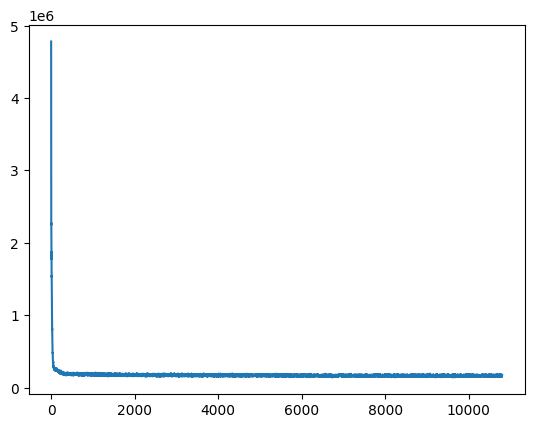

In [63]:
losses_per_epoch = []

pbar = tqdm(range(epochs),)

for epoch in range(epochs):
    losses = []
    #print(epoch)
    
    for step in range(steps_per_epoch):
        # Get a random batch.
        rng_epoch, rng_x, rng_b, rng = jax.random.split(rng, 4)
        batch_x = jax.random.randint(rng_x, shape=(batch_size,), minval=0, maxval=tg_dset_size)
        batch_b = jax.random.randint(rng_b, shape=(batch_size,), minval=0, maxval=bkg_dset_size)

        
        # Compute gradients and losses.
        grads, loss = apply_model( # pylint: disable=not-callable
                rng_epoch, state, target[batch_x], background[batch_b], sigma_noise=sigma_noise
        )
        state = update_model( # pylint: disable=not-callable
                        state, grads
        )
        losses.append(loss)
    
    losses_per_epoch.append(losses)
    pbar.set_postfix({'loss': f'{jnp.asarray(losses).mean():.3f}'})
    
losses_per_epoch = jnp.concatenate(jnp.asarray(losses_per_epoch))
plt.plot(losses_per_epoch)

In [64]:
rng_samples, rng = jax.random.split(rng)
x_samples, y_samples, latents = state.apply_fn({'params': state.params}, rng_samples, target, background,)

x_samples.shape, y_samples.shape


((13824, 784), (32768, 784))

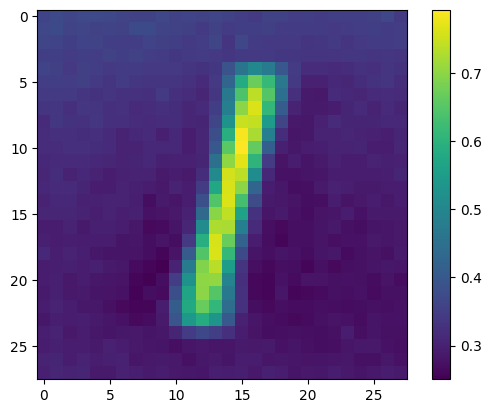

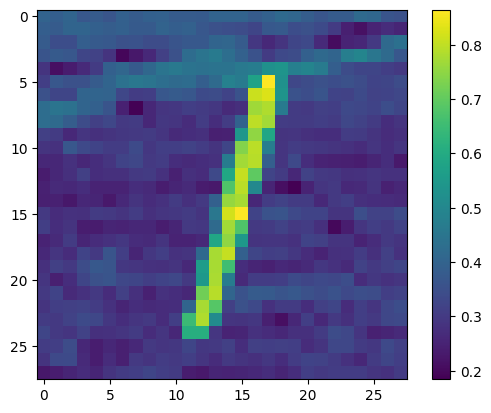

In [65]:
idx = 1290

x_post = x_samples[idx].reshape(28, 28)

plt.imshow(x_post)
plt.colorbar()
plt.show()


x_post = target[idx].reshape(28, 28)

plt.imshow(x_post)
plt.colorbar()
plt.show()

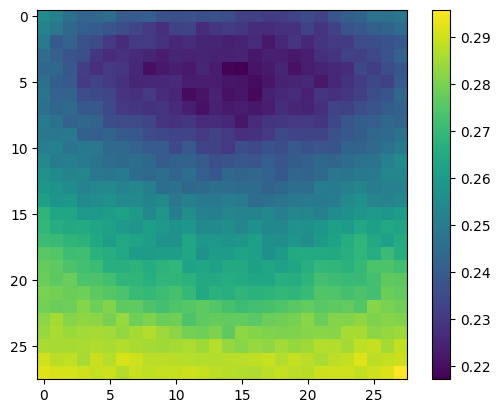

In [66]:
y_post = y_samples[idx].reshape(28, 28)

plt.imshow(y_post)
plt.colorbar()
plt.show()



In [67]:
def get_denoised_samples(rng, target, background, state):
    rng_samples, rng = jax.random.split(rng)
    tx, zx, zy, latent_params = state.apply_fn({'params': state.params}, 
                                               rng_samples, 
                                               target, 
                                               background, 
                                               method="sample_latents")
    

    
    

In [68]:
rng_samples, rng = jax.random.split(rng)
target_denoised = state.apply_fn({'params': state.params}, rng_samples, target, background, method="denoise_samples")

target_denoised.shape

(13824, 784)

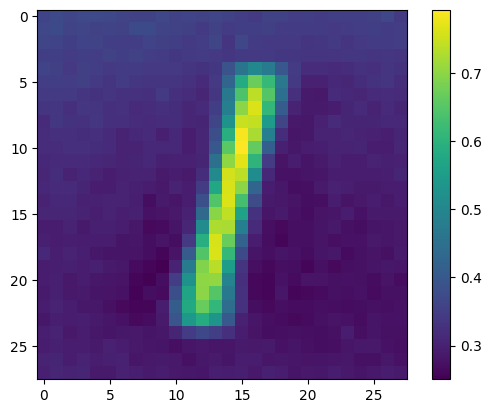

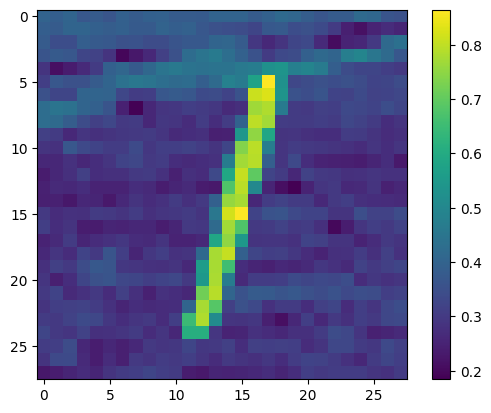

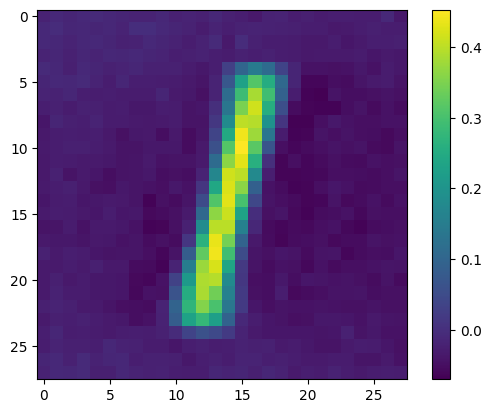

In [69]:
idx = 1290

x_post = x_samples[idx].reshape(28, 28)

plt.imshow(x_post)
plt.colorbar()
plt.show()


x_post = target[idx].reshape(28, 28)

plt.imshow(x_post)
plt.colorbar()
plt.show()

x_post = target_denoised[idx].reshape(28, 28)

plt.imshow(x_post)
plt.colorbar()
plt.show()

In [71]:
target_denoised.mean(), x_samples.mean(), target.mean(), background.mean()

(Array(-0.00275902, dtype=float32),
 Array(0.5067405, dtype=float32),
 Array(0.50671196, dtype=float32),
 Array(0.44711894, dtype=float32))